# Multivariate Normal Likelihood with Multivariate Normal Prior

This is a simple model where our data, $y$, is modelled as a multivariate normal RV with uncorrelated noise.

$L(x) = p(y | x) = \mathcal{N}[y \mid x,\Sigma]$

and

$p(x) = \mathcal{N}[x \mid \mu, \sigma^2 \mathbf{I}]$.

The analytic evidence for this model is,

$Z = p(y) = \mathcal{N}[y \mid \mu, \Sigma + \sigma^2 \mathbf{I}]$

The posterior is also a multivariate normal distribution,

$p(x \mid y) = \mathcal{N}[\mu', \Sigma']$

where

$\mu' = \sigma^2 \mathbf{I} (\sigma^2 \mathbf{I} + \Sigma)^{-1} y + \Sigma (
    \sigma^2 \mathbf{I} + \Sigma)^{-1}  \mu$

and

$\Sigma' = \sigma^2 \mathbf{I}  (\sigma^2 \mathbf{I}  + \Sigma)^{-1} \Sigma$


In [6]:

import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp

from jaxns import DefaultNestedSampler
from jaxns import Model
from jaxns import Prior

tfpd = tfp.distributions

In [7]:
from jax._src.scipy.linalg import solve_triangular


def log_normal(x, mean, cov):
    L = jnp.linalg.cholesky(cov)
    dx = x - mean
    dx = solve_triangular(L, dx, lower=True)
    return -0.5 * x.size * jnp.log(2. * jnp.pi) - jnp.sum(jnp.log(jnp.diag(L))) - 0.5 * dx @ dx


# define our data and prior
ndims = 16
prior_mu = 15 * jnp.ones(ndims)
prior_cov = jnp.diag(jnp.ones(ndims)) ** 2

data_mu = jnp.zeros(ndims)
data_cov = jnp.diag(jnp.ones(ndims)) ** 2
data_cov = jnp.where(data_cov == 0., 0.99, data_cov)

true_logZ = log_normal(data_mu, prior_mu, prior_cov + data_cov)

J = jnp.linalg.solve(data_cov + prior_cov, prior_cov)
post_mu = prior_mu + J.T @ (data_mu - prior_mu)
post_cov = prior_cov - J.T @ (prior_cov + data_cov) @ J

print("True logZ={}".format(true_logZ))
print("True post_mu={}".format(post_mu))
print("True post_cov={}".format(post_cov))


True logZ=-123.01473999023438
True post_mu=[14.109793 14.109791 14.109794 14.109795 14.109792 14.109793 14.109793
 14.109791 14.109793 14.109794 14.109793 14.109793 14.109792 14.109793
 14.109794 14.109793]
True post_cov=[[0.0680728  0.05817217 0.05817196 0.05817205 0.0581721  0.05817203
  0.05817202 0.05817205 0.05817201 0.05817205 0.05817202 0.05817197
  0.05817199 0.05817199 0.05817198 0.05817195]
 [0.05817217 0.0680719  0.05817202 0.05817205 0.0581721  0.05817205
  0.05817205 0.05817203 0.05817202 0.05817201 0.05817203 0.05817198
  0.05817199 0.05817199 0.05817192 0.05817193]
 [0.05817197 0.058172   0.0680728  0.05817198 0.05817212 0.05817208
  0.05817208 0.05817204 0.05817202 0.05817202 0.05817204 0.05817203
  0.05817201 0.05817202 0.05817195 0.05817201]
 [0.05817204 0.05817205 0.05817197 0.06807292 0.05817207 0.05817203
  0.05817204 0.05817204 0.058172   0.05817201 0.05817201 0.05817201
  0.05817199 0.058172   0.05817195 0.05817197]
 [0.05817207 0.05817202 0.05817207 0.05817201 0

In [8]:



def prior_model():
    x = yield Prior(tfpd.MultivariateNormalTriL(loc=prior_mu, scale_tril=jnp.linalg.cholesky(prior_cov)), name='x')
    return x


# The likelihood is a callable that will take
def log_likelihood(x):
    return log_normal(x, data_mu, data_cov)


model = Model(prior_model=prior_model,
              log_likelihood=log_likelihood)


In [9]:
import jax

# Create the nested sampler class. In this case without any tuning.
ns = DefaultNestedSampler(
    model=model,
    max_samples=1e6,
    parameter_estimation=True,
    verbose=True)

termination_reason, state = jax.jit(ns)(random.PRNGKey(42654))
results = ns.to_results(termination_reason=termination_reason, state=state)

# We can always save results to play with later
ns.save_results(results, 'save.npz')
# loads previous results by uncommenting below
# results = load_results('save.npz')



-------Num samples: 8640
Num likelihood evals: 5539
Efficiency: 1.4731900691986084log(L) contour: -728.3695068359375
log(Z) est.: -300.04827880859375 +- 0.8311780691146851
-------Num samples: 16800
Num likelihood evals: 20408
Efficiency: 0.3998431861400604log(L) contour: -544.81689453125
log(Z) est.: -237.0644073486328 +- 0.8337075710296631
-------Num samples: 24960
Num likelihood evals: 42750
Efficiency: 0.19087719917297363log(L) contour: -449.32080078125
log(Z) est.: -212.8740997314453 +- 0.8348050117492676
-------Num samples: 33120
Num likelihood evals: 71617
Efficiency: 0.11393942683935165log(L) contour: -386.14788818359375
log(Z) est.: -209.5166778564453 +- 0.8285486698150635
-------Num samples: 41280
Num likelihood evals: 106851
Efficiency: 0.07636802643537521log(L) contour: -334.6083984375
log(Z) est.: -192.8569793701172 +- 0.8216135501861572
-------Num samples: 49440
Num likelihood evals: 146926
Efficiency: 0.05553816258907318log(L) contour: -294.7420349121094
log(Z) est.: -189

--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 5104310
samples: 432960
phantom samples: 407040
likelihood evals / sample: 11.8
phantom fraction (%): 94.0%
--------
logZ=-122.661 +- 0.0014
H=-33.66
ESS=4029
--------
x[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
x[0]: 14.09 +- 0.26 | 13.77 / 14.08 / 14.42 | 14.17 | 13.22
x[1]: 14.09 +- 0.25 | 13.77 / 14.08 / 14.41 | 14.22 | 13.17
x[2]: 14.09 +- 0.26 | 13.77 / 14.08 / 14.42 | 14.17 | 13.28
x[3]: 14.09 +- 0.26 | 13.78 / 14.08 / 14.43 | 14.16 | 13.05
x[4]: 14.09 +- 0.25 | 13.78 / 14.08 / 14.41 | 14.2 | 13.11
x[5]: 14.09 +- 0.25 | 13.79 / 14.08 / 14.41 | 14.24 | 13.15
x[6]: 14.09 +- 0.25 | 13.78 / 14.08 / 14.42 | 14.23 | 13.09
x[7]: 14.09 +- 0.26 | 13.77 / 14.08 / 14.43 | 14.22 | 13.24
x[8]: 14.09 +- 0.26 | 13.77 / 14.08 / 14.42 | 14.16 | 13.31
x[9]: 14.09 +- 0.25 | 13.78 / 14.08 / 14.42 | 14.23 | 13.1
x[10]: 14.09 +- 0.26 | 13.78 / 14.08 / 14.42 | 14.2 | 13.17
x[11]: 14.09 +

/home/albert/git/jaxns/jaxns/plotting.py:47: RuntimeWarning: divide by zero encountered in divide
  efficiency = 1. / num_likelihood_evaluations_per_sample


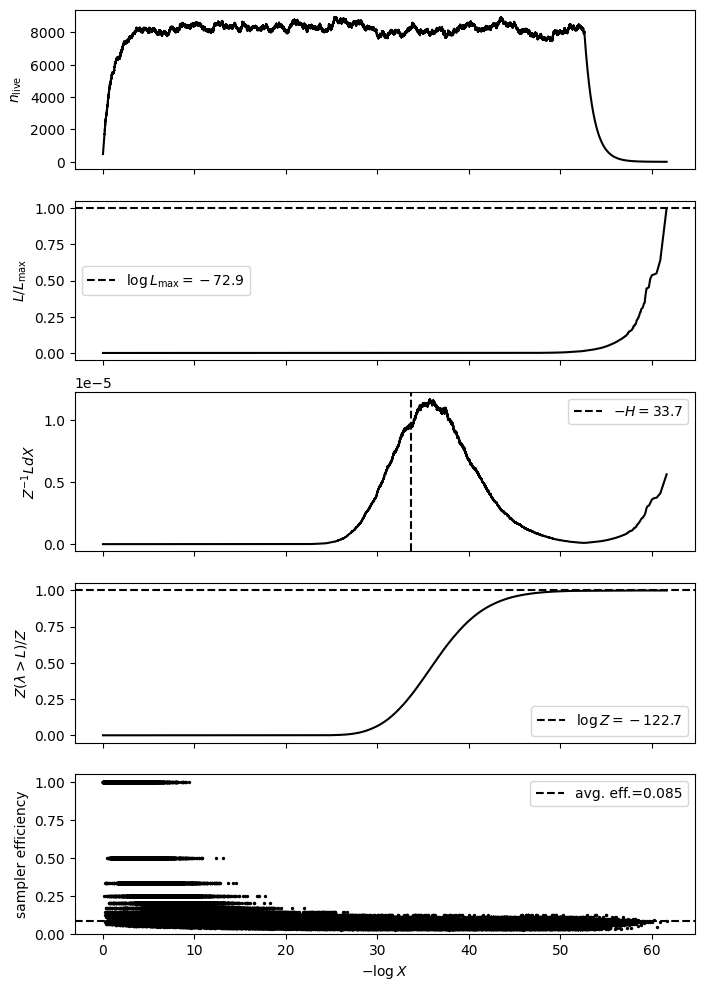

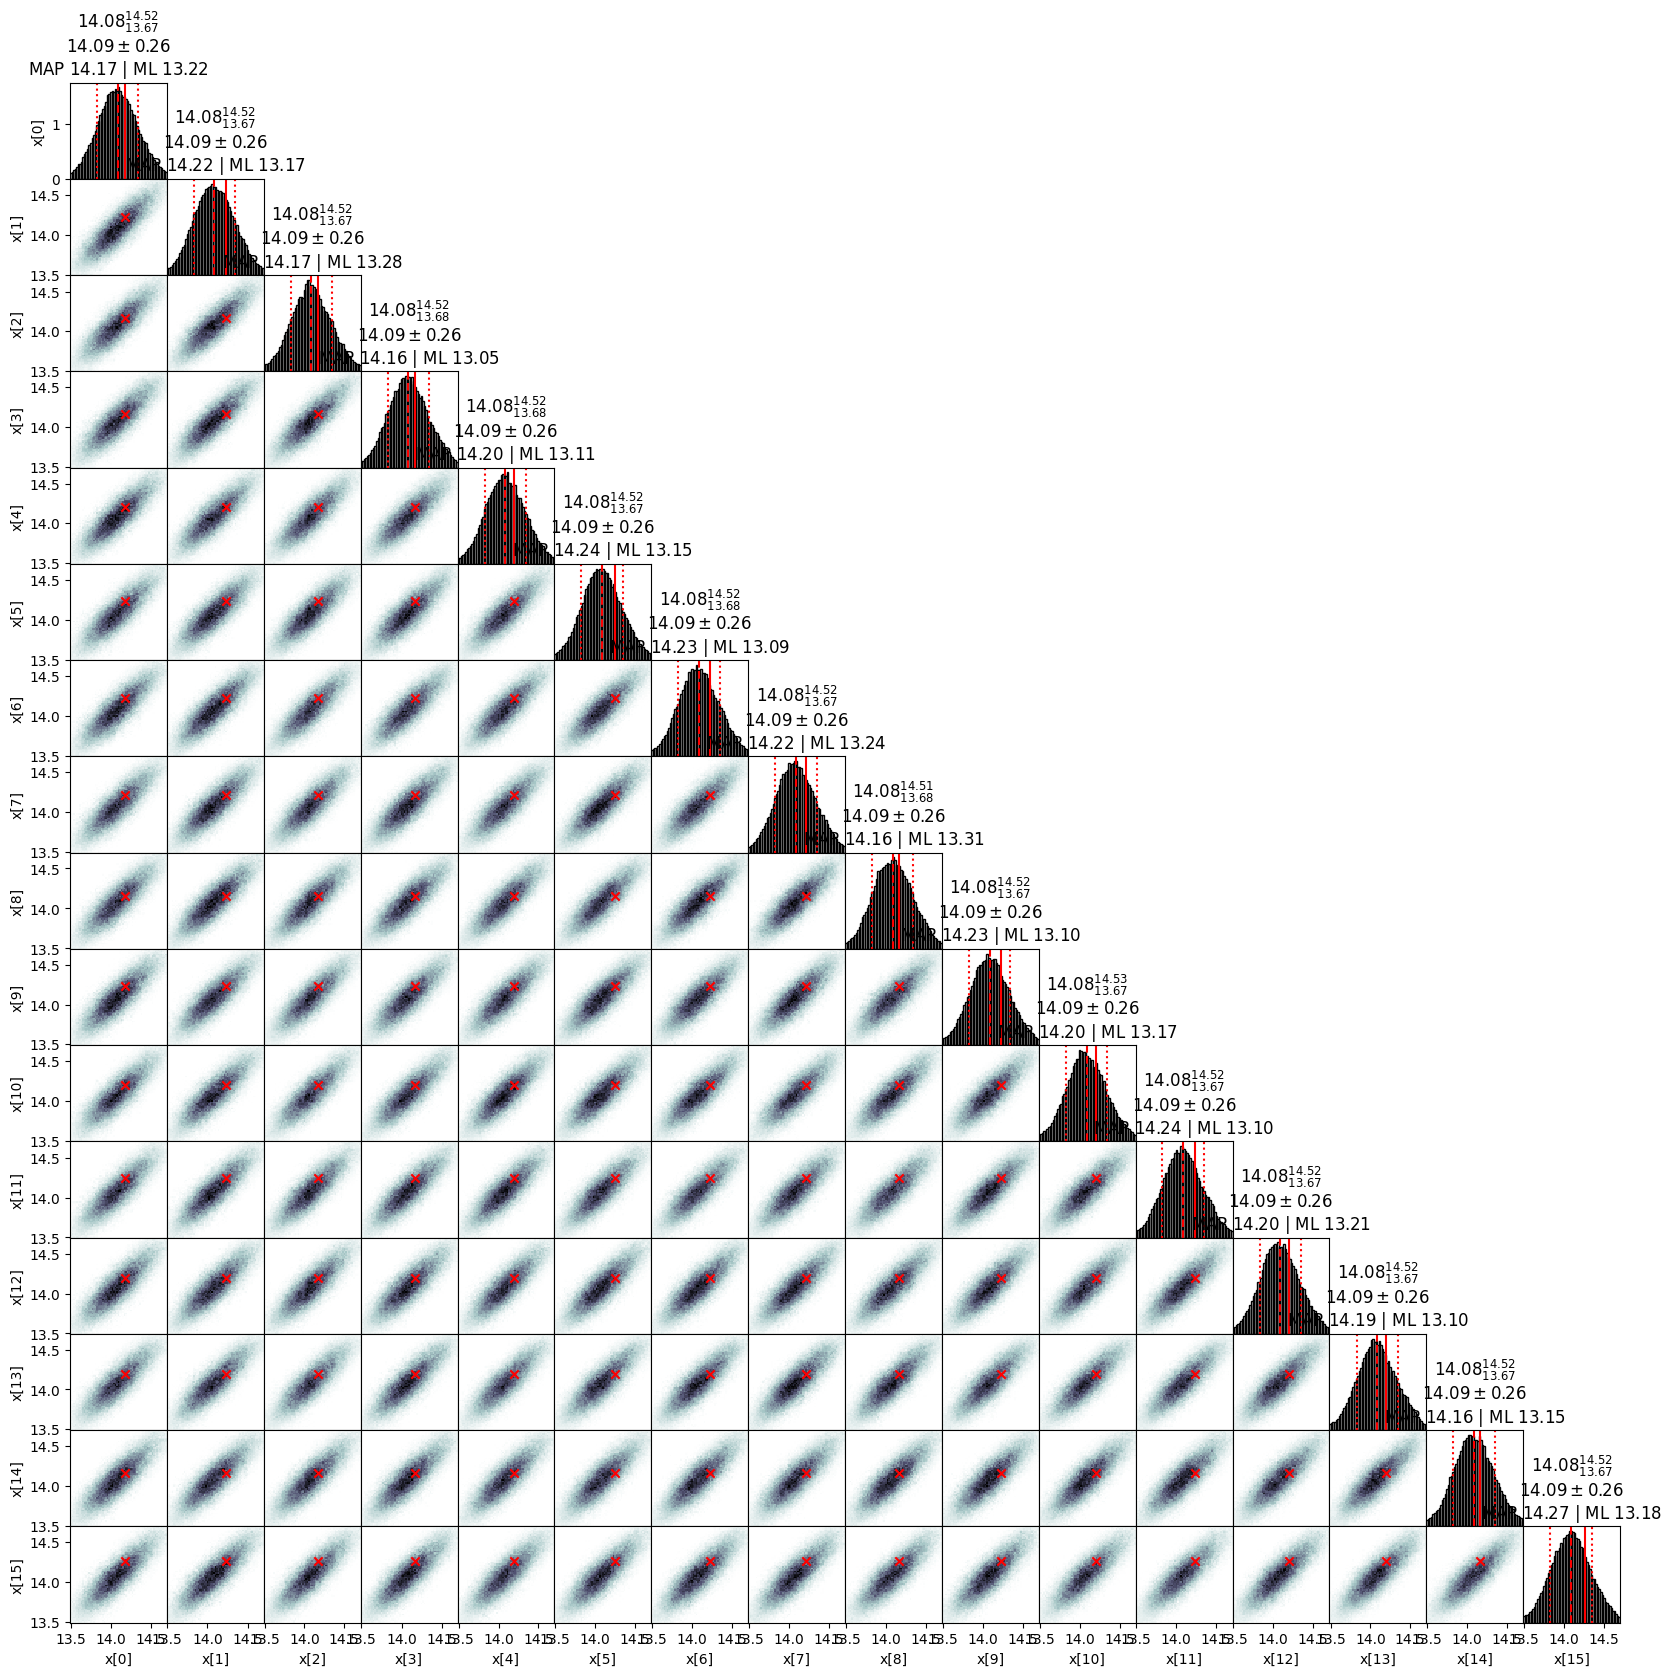

In [10]:
# We can use the summary utility to display results
ns.summary(results)
# We plot useful diagnostics and a distribution cornerplot
ns.plot_diagnostics(results)
ns.plot_cornerplot(results)
